# Übungsblatt 2 (Sprach- und Signalverarbeitung)


## 1 Short-time Fourier transform


In [6]:
using WAV, Plots, IJulia

module Audio

using WAV

struct T
    samples :: Array{Float64,2}
    sampling_rate :: Float32
end

timestamps = audio -> 1/audio.sampling_rate * (0:(length(audio.samples) - 1))

readA = function(filepath)
    (s,fs) = wavread(filepath)
    print(typeof(s))
    Audio(s, fs)
end



play = function(audio)
display("audio/wav",(audio.samples, audio.sampling_rate))
end
end

using Audio

speech1 = readA("Audio/speech1.wav")
phone = readA("Audio/phone.wav")

LoadError: [91mUndefVarError: readA not defined[39m

Array{Float64,2}Array{Float64,2}

45466-element Array{Float32,1}:
 0.0      
 6.25f-5  
 0.000125 
 0.0001875
 0.00025  
 0.0003125
 0.000375 
 0.0004375
 0.0005   
 0.0005625
 0.000625 
 0.0006875
 0.00075  
 ⋮        
 2.84088  
 2.84094  
 2.841    
 2.84106  
 2.84113  
 2.84119  
 2.84125  
 2.84131  
 2.84138  
 2.84144  
 2.8415   
 2.84156  

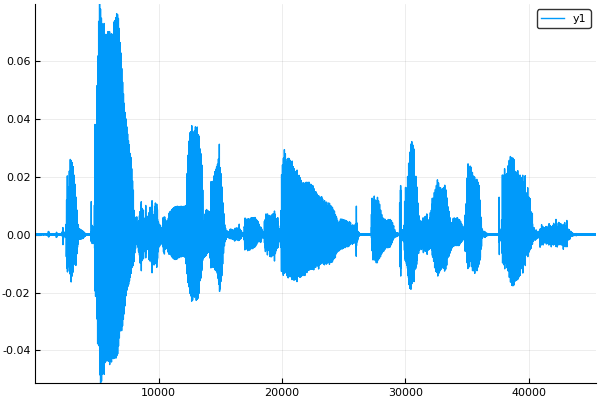

In [2]:
plot(s)

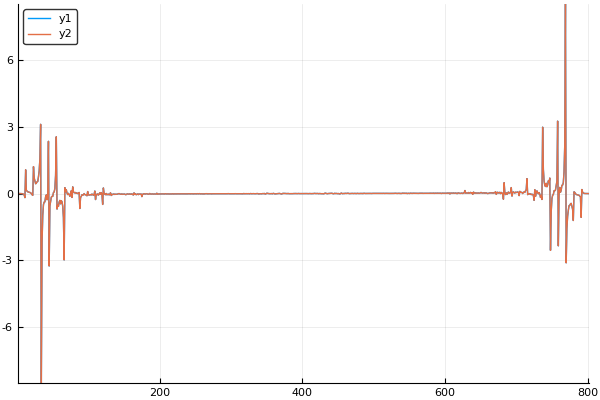

In [3]:
t = s[5100:5900]

fft_t = vcat(fft(t),0)
rev = reverse(fft_t)
plot([imag.(fft_t),-imag.(rev)])

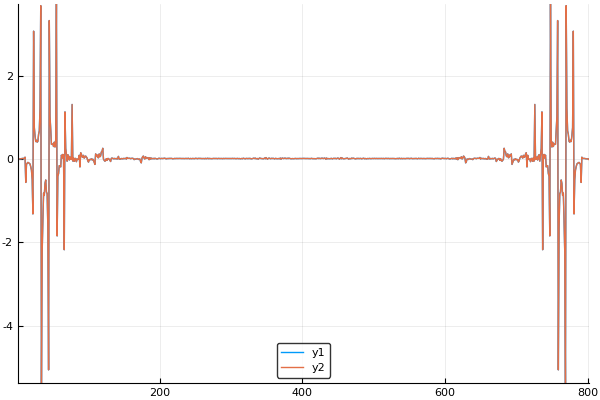

In [4]:
plot([real.(fft_t),real.(rev)])

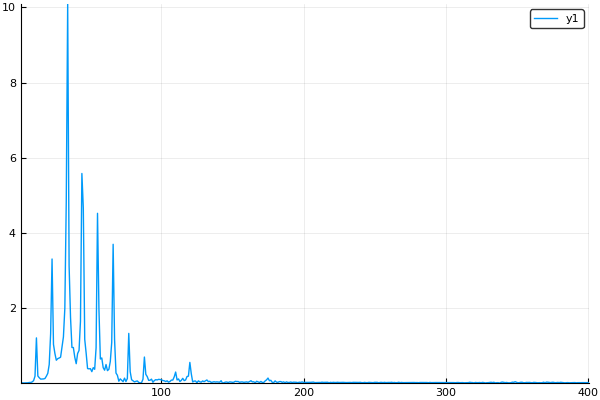

In [5]:
fft_t_trunc = fft_t[1:Int(length(fft_t)/2)]
plot(abs.(fft_t_trunc))

Note the symmetry of the spectrum.

The spectrum is (conjugate-)symmetric as Fourier transformation maps complex conjugation to inversion:
$$F(\overline{f})(\chi) = \int \overline{f} \overline{\chi} = \overline{\int f\overline{\chi^{-1}}} = \overline{F(f)(\chi^{-1})}$$

Note that for characters $\chi^{-1} = \overline{\chi}$ holds.

Because $f = \overline{f}$ for real function $f$, we have $F(f)(i) = F(\overline{f})(i) = \overline{F(f)(-i)}$.

This shows: one half of the spectrum is __redundant__!

The first peak is the fundamental frequency (it is at 12, and there are 12 periods in the frame in question).

Thereafter we find the overtones at $11*k, k =2,...,8,10,11 $ (roughly speaking)

In [7]:
my_windowing = function(v_signal, sampling_rate; frame_length=32e-3, frame_shift=16e-3)
    samples_per_frame = Int(floor(frame_length * sampling_rate))
    samples_per_shift = Int(floor(frame_shift * sampling_rate))
    shift_count = 1 + Int(floor((length(v_signal) - samples_per_frame)/samples_per_shift))

    m_frames = zeros(samples_per_shift, shift_count)
    for j in 1:shift_count
        for i in 1:samples_per_shift
            m_frames[i,j] = v_signal[samples_per_shift*(j-1)+i]
        end
    end
    v_time_frame = frame_length/2 + frame_shift * (0:(shift_count-1))

    (m_frames, v_time_frame)
end



my_stft = function(v_signal, sampling_rate, v_analysis_window; frame_length=32e-3, frame_shift=16e-3)
    (m_frames, v_time) = my_windowing(v_signal, sampling_rate, frame_length=frame_length, frame_shift=frame_shift)

    (samples_per_frame, frame_count) = size(m_frames)
    freqs = Int(ceil(frame_count / 2))
    m_stft = zeros(samples_per_frame, freqs)
    for j in 1:frame_count
        m_stft[:,j] = fft(m_frames[:,j] .* v_analysis_window(samples_per_frame))[2:(freqs+1)]
    end
    v_freq = sampling_rate/samples_per_frame * (1:freqs)
    return (m_stft, v_freq, v_time)
end


(::#10) (generic function with 1 method)

_Q: How to compute the frequency?_

Among the set of peaks, find the one corresponding to the lowest frequency?

_Q: How many sampling points in the spectrum after removal of mirrored part?_

If the frame has $n$ windows, we remove the 0 and take $\ell = \lceil\frac{n-1}{2}\rceil$.
- Case 1: $n = 1 + \ell + 1 + \ell$ (0 and Nyquist bin)
- Case 2: $n = 1 + \ell + \ell$ (no Nyquist bin)

## 2 Spectral Analysis

> If not stated otherwise, the following exercises should be performed for both signals.




### (a)

> Use your own function to compute the STFT and plot the logarithmic magnitude spectrogram in dB using the following parameters.
>   - frame length: 32 ms
>   - frame shift: 8 ms
>   - window function: periodic Hann window
>    You can create the Hann window with `v_analysis_window = hann(frame_length_samples, 'periodic')`, where
`frame_length_samples` is the frame length in samples.
>    The spectrogram can be plotted using the following Matlab command
>    ```imagesc ( v_time , v_freq , 10* log10 ( max ( abs ( m_stft ) .^2 , 10^( -15) ) )```
>    It tells Matlab to use the vector `v_time` for the x-axis and `v_freq` for the y-axis. Here, the vector `v_time` contains the time instants for each block / each spectrum.
>    The `imagesc` command uses by default a reversed y-axis.
>    The axis can be inverted by using `axis xy` after the `imagesc` call.
>    - Why is the magnitude plotted in dB? Why is it reasonable to introduce a lower limit? What is the lower limit in the command given above in dB?

### (b)

> Identify the voiced, unvoiced and silence segments in the spectrogram by eye.
>    - Describe their appearance and what distinguishes them. Is it possible to identify the different voicing types more easily in comparison to the time domain representation?

### (c)

> Produce the same plot as in a) but this time using a frame length corresponding to 8 ms and a frame shift of 2 ms.
>    Further, create a plot for a frame length of 128 ms and a frame shift of 32 ms.
>    - How well can you distinguish single sinusoidal components? Short impulses? Explain the influence of the different parameter settings.


### (d)

> Only for the speech signal estimate the fundamental frequency using the auto-correlation-based method of the last exercise session. Plot the estimated fundamental frequency onto the spectrogram. The parameter setting should be the one used in a). This can be achieved by issuing the following commands after the `imagesc` command:
>    ```
>    hold on
>    plot ( v_time , v_fundamental_frequency , ’k ’)
>    hold off
>    ```
>   - Do the estimated fundamental frequencies follow the harmonic structures in the spectrogram? You may also want to plot higher harmonics by multiplying your estimated fundamental frequencies with a positive integer value. This way, you can see the precision of the estimated frequencies more precisely.

## 3 Synthesis from the STFT domain (Inverse STFT)

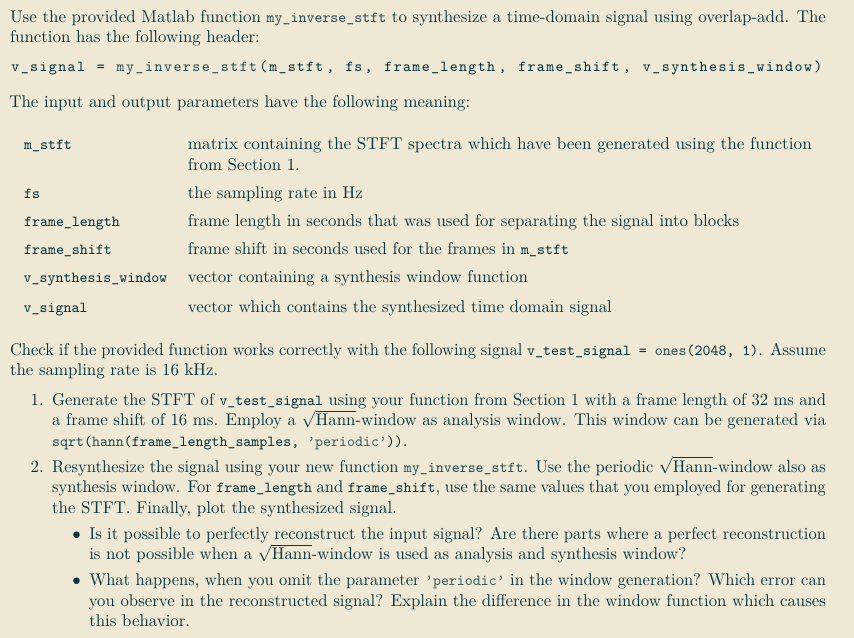